In [1]:
library(tidyverse)
library(lubridate)
library(ggrepel)
library(tools)
options(scipen = 999)
setwd("~/Google Drive/PPUA5302 Info Design & Visual Analytics/my_digital_shadows")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
# data cleaning
mr <- read_csv("ActivityDetails.csv")
mr[47, 4] <- NA
mr <- mr[-c(3, 12, 31, 32, 48), ]
mr <- mr[seq(dim(mr)[1],1),]
# https://stackoverflow.com/questions/39975317/how-to-reverse-the-order-of-a-dataframe-in-r

mr <- mr %>%
  mutate(Description = str_replace_all(Description, ".+ SPND", "Authorized User Offer")) %>%
  mutate(Description = str_replace_all(Description, ".+\\/.+", "Sign-up Bonus")) %>%
  mutate(Description = str_replace_all(Description, "Retention.+", "Retention")) %>%
  mutate(Description = str_replace_all(Description, "Targeted Spend & Get Offers", "Targeted Spend Offers")) %>%
  mutate(Description = str_replace_all(Description, "20% Extra Points Apr 2018", "Spend Reward")) %>%
  mutate(Description = str_replace_all(Description, ".+\\-\\d+", "Spend Reward")) %>%
  mutate(Description = str_replace_all(Description, "Amazon 3X Membership Rewards", "Spend Reward")) %>%
  mutate(Description = str_replace_all(Description, "Amex Express Checkout Offer", "Spend Reward")) %>%
  mutate(Description = str_replace_all(Description, "Points Adjustment", "Spend Reward")) %>%
  mutate(Date = str_replace_all(mdy(Date), "(\\d+-\\d+)-\\d+", "\\1"))

Parsed with column specification:
cols(
  Date = col_character(),
  Category = col_character(),
  Description = col_character(),
  Points = col_number(),
  multiple = col_character(),
  points = col_integer()
)


In [3]:
mr2 <- mr %>%
  group_by(Description) %>%
  summarise("Total Points" = sum(Points, na.rm = T))

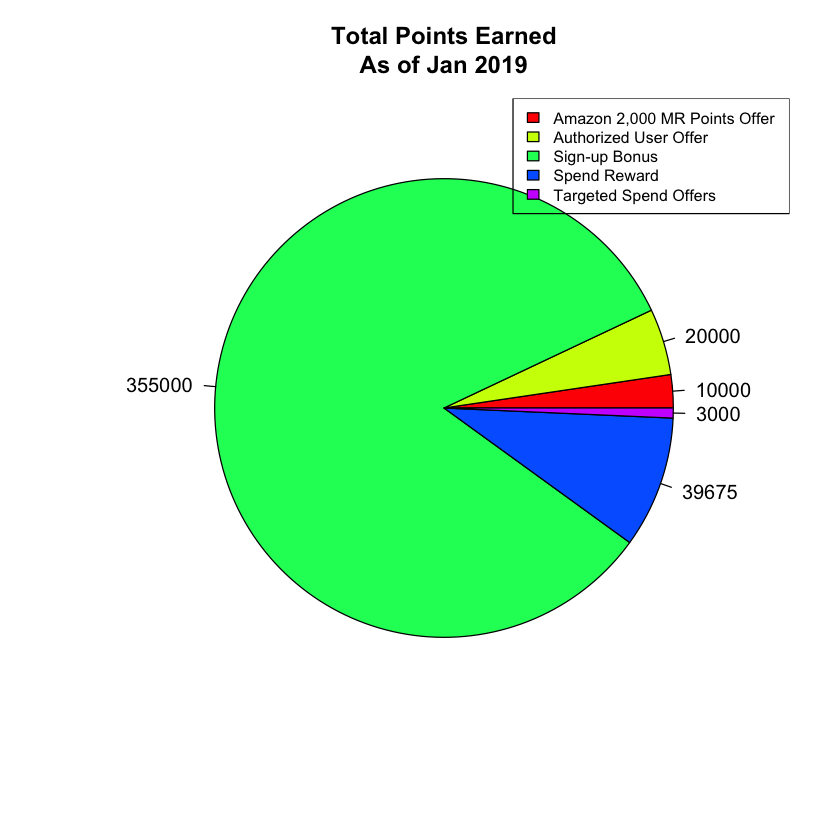

In [4]:
pie(mr2$`Total Points`, labels = mr2$`Total Points`, main = "Total Points Earned\nAs of Jan 2019", col = rainbow(length(mr2$`Total Points`)))
legend("topright", mr2$Description, cex = 0.8, fill = rainbow(length(mr2$`Total Points`)))

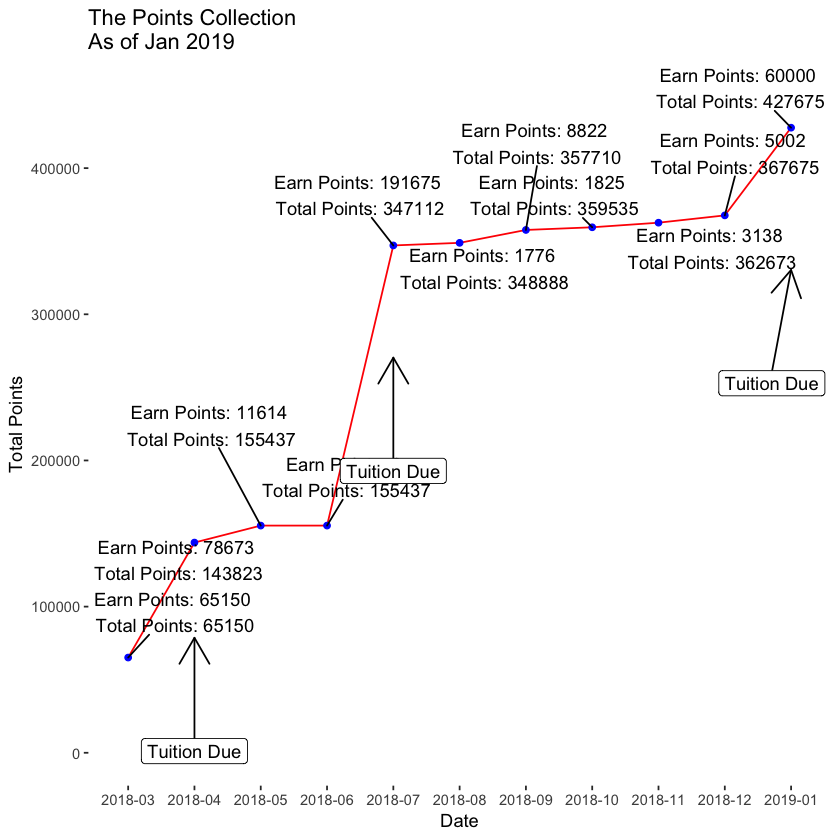

In [5]:
mr3 <- mr %>%
  group_by(Date) %>%
  summarise(Points = sum(Points, na.rm = T))
mr3[11,] <- c("2018-06", 0)
mr3 <- mr3[order(mr3$Date),]
mr3 %>%
  ggplot(aes(Date, cumsum(Points), group = 1)) +
    geom_line(color = "red") +
    geom_point(color = "blue") +
    geom_text_repel(aes(Date, cumsum(Points), label = paste("Earn Points:", Points, "\nTotal Points:", cumsum(Points)), vjust = -1)) +
    theme(panel.background = element_blank()) +
    ylab("Total Points") + coord_cartesian(ylim = c(0, 450000)) +
    ggtitle(label = "The Points Collection \nAs of Jan 2019") +
    geom_label_repel(data =  mr3[mr3$Date %in% c("2018-04", "2018-07", "2019-01"), ], mapping = aes(Date, cumsum(Points), label = "Tuition Due"), vjust = 5, arrow = arrow())
# https://stackoverflow.com/questions/15844919/cumulative-plot-using-ggplot2

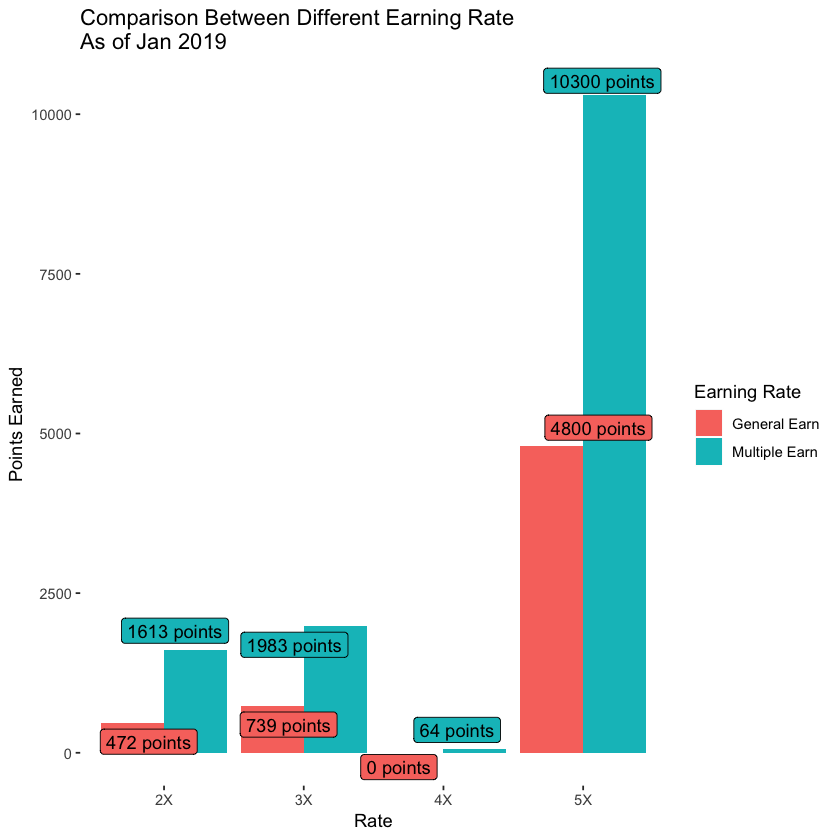

In [6]:
mr %>%
  filter(Description == "Spend Reward", !is.na(multiple)) %>%
  group_by(multiple) %>%
  summarise(`Multiple Earn` = sum(points), `General Earn` = sum(Points, na.rm = T) - `Multiple Earn`) %>%
  gather(-multiple, key = `earn rate`, value = `points earned`) %>%
  ggplot(aes(multiple, `points earned`, fill = `earn rate`)) +
    geom_col(position = "dodge") +
    geom_label_repel(aes(multiple, `points earned`, label = paste(`points earned`, "points")), show.legend = F) +
  ylab("Points Earned") + xlab("Rate") + guides(fill=guide_legend(title="Earning Rate")) +
  theme(panel.background = element_blank()) +
  ggtitle(label = "Comparison Between Different Earning Rate\nAs of Jan 2019")
# https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot

In [7]:
plat <- read_csv("Plat.csv")
schwab <- read_csv("Plat_Swchab.csv")
mb <- read_csv("Plat_MB.csv")
plat_am <- read_csv("Plat_Am.csv")
prg <- read_csv("PRG.csv")
gold_am <- read_csv("PRG_Am.csv")
green <- read_csv("Green.csv")
plat$type <- "Platinum Card"
schwab$type <- "Platinum Card for Charlse Schwab"
mb$type <- "Platinum Card for Mecerdes Benz"
plat_am$type <- "Platinum Card for Ameriprise"
prg$type <- "Gold Card"
gold_am$type <- "Gold Card for Ameriprise"
green$type <- "Green Card"
complete <- bind_rows(plat, schwab, mb, plat_am, prg, gold_am, green)

complete <- complete %>%
  select(Description, Amount, type) %>%
  filter(!str_detect(Description, "PARTNERS HEALTHCARE|THANK YOU")) %>%
  mutate(Description = str_replace(Description, "(AMERICAN AIRLINES).+", "\\1")) %>%
  mutate(Description = str_replace_all(Description, "GIFT.+", "Gift Card")) %>%
  mutate(Description = str_replace_all(Description, "(AMAZON).+", "\\1")) %>%
  mutate(Description = str_replace_all(Description, ".+(ITUNES).+", "\\1")) %>%
  mutate(Description = str_replace(Description, "MCDONALD'S", "McDonald's")) %>%
  mutate(Description = str_replace_all(Description, "(WALMART).+", "\\1")) %>%
  mutate(Description = str_replace_all(Description, "VZWIRELESS.+", "Verizon")) %>%
  mutate(Description = str_replace_all(Description, "SAKS.+", "Saks Fifth Avenue")) %>%
  mutate(Description = str_replace_all(Description, "(DELTA AIR LINES).+", "\\1")) %>%
  mutate(Description = str_replace_all(Description, "(7-ELEVEN).+", "\\1")) %>%
  mutate(Description = str_replace_all(Description, "SEAMLSS.+", "Seamless")) %>%
  mutate(Description = toTitleCase(tolower(Description)))

charge <- complete %>%
  filter(Amount > 0, !str_detect(Description, "Interest"))
credit <- complete %>%
  filter(Amount < 0) %>%
  mutate(Amount = as.numeric(str_replace_all(Amount, "-(.+)", "\\1")),
         Description = str_replace_all(Description, ".+(Hilton Gift Card)", "\\1")) %>%
  group_by(Description, Amount, type) %>%
  summarise(Total = sum(Amount)) %>%
  filter(Total > 9)

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  `Transaction Id` = col_double(),
  Description = col_character(),
  `Card Member` = col_character(),
  `Card Number` = col_integer(),
  Amount = col_double()
)
Parsed with column specification:
cols(
  Date = col_date(format = ""),
  `Transaction Id` = col_double(),
  Description = col_character(),
  `Card Member` = col_character(),
  `Card Number` = col_integer(),
  Amount = col_double()
)
Parsed with column specification:
cols(
  Date = col_date(format = ""),
  `Transaction Id` = col_double(),
  Description = col_character(),
  `Card Member` = col_character(),
  `Card Number` = col_integer(),
  Amount = col_double()
)
Parsed with column specification:
cols(
  Date = col_date(format = ""),
  `Transaction Id` = col_double(),
  Description = col_character(),
  `Card Member` = col_character(),
  `Card Number` = col_integer(),
  Amount = col_double()
)
Parsed with column specification:
cols(
  Date = col_date(format

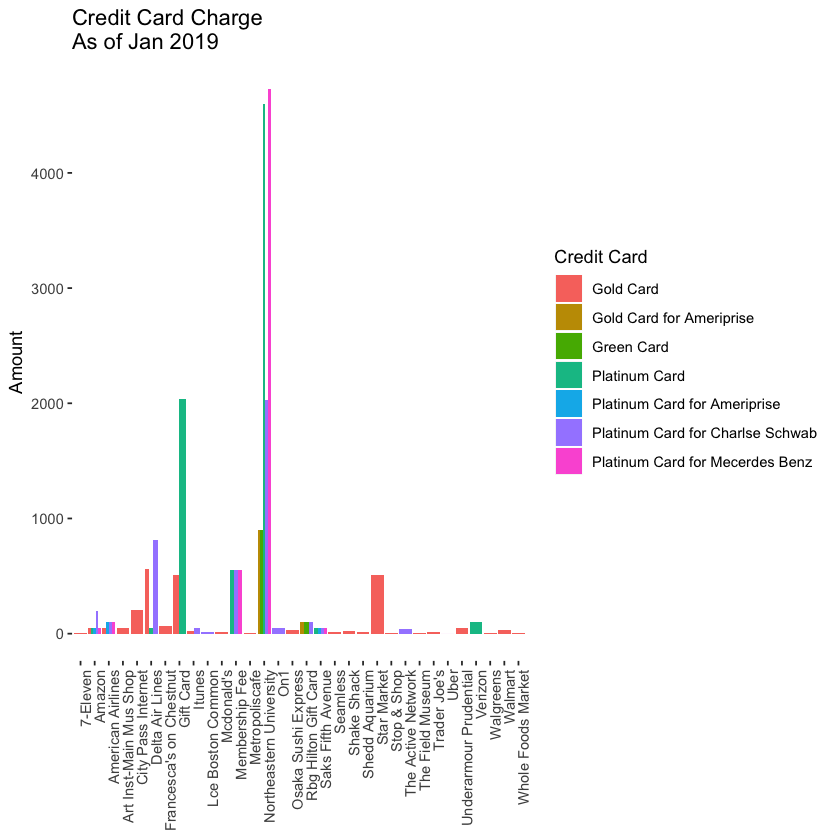

In [10]:
ggplot(charge, aes(Description, Amount, fill = type)) +
  geom_col(position = "dodge") + 
  guides(fill=guide_legend(title="Credit Card")) +
  ggtitle(label = "Credit Card Charge \nAs of Jan 2019") + xlab(NULL) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1), panel.background = element_blank())

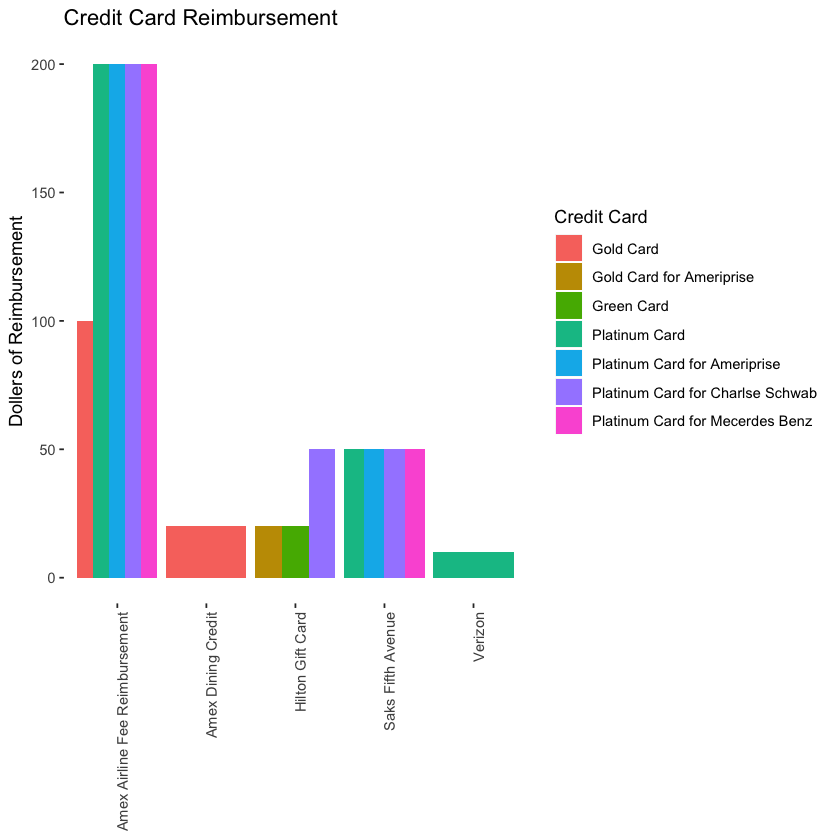

In [9]:
ggplot(credit, aes(Description, Total, fill = type)) +
  geom_col(position = "dodge") + 
  guides(fill=guide_legend(title="Credit Card")) +
  ggtitle(label = "Credit Card Reimbursement") + xlab(NULL) + ylab("Dollers of Reimbursement") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1), panel.background = element_blank())